In [ ]:
import numpy as np
from scipy.stats import norm

# =================================================================
# 1. FONCTION PRINCIPALE : BLACK-SCHOLES CALL
# =================================================================
def black_scholes_call(S0, K, T, r, sigma):
    """Calcule le prix d'une Option d'Achat (Call) Européenne."""
    if T <= 0:
        return max(S0 - K, 0)

    # Calcul des variables intermédiaires d1 et d2
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calcul du prix du Call (C)
    C = (S0 * norm.cdf(d1)) - (K * np.exp(-r * T) * norm.cdf(d2))

    return C

# =================================================================
# 2. FONCTION POUR LE PUT : VIA PARITÉ CALL-PUT
# =================================================================
def black_scholes_put(S0, K, T, r, sigma):
    """Calcule le prix d'une Option de Vente (Put) Européenne."""
    # Étape 1: Calculer le prix du Call (C)
    C = black_scholes_call(S0, K, T, r, sigma)

    # Étape 2: Appliquer la formule de Parité
    P = C - S0 + K * np.exp(-r * T)

    return P

In [ ]:
# Définir les inputs (variables) - CAS D'EXEMPLE
S0 = 100.0   # Prix actuel (100€)
K = 100.0    # Prix d'exercice (100€)
T = 1.0      # Échéance dans 1 an
r = 0.05     # Taux sans risque (5%)
sigma = 0.2  # Volatilité (20%)

# Calcul et affichage des résultats
prix_call = black_scholes_call(S0, K, T, r, sigma)
prix_put = black_scholes_put(S0, K, T, r, sigma)

print(f"--- Pricer Black-Scholes ---")
print(f"Prix du Call (Droit d'Achat):   {prix_call:.4f} €")
print(f"Prix du Put (Droit de Vente):   {prix_put:.4f} €")

--- Pricer Black-Scholes ---
Prix du Call (Droit d'Achat):   10.4506 €
Prix du Put (Droit de Vente):   5.5735 €


In [ ]:
# =================================================================
# 3. FONCTION DE VALORISATION PAR MONTE CARLO (M.C.)
# =================================================================

def monte_carlo_pricer(S0, K, T, r, sigma, num_simulations):
    """
    Valorise une option d'achat (Call) Européenne par simulation Monte Carlo.
    """
    # 1. Génération de nombres aléatoires pour simuler les rendements
    # On tire des nombres aléatoires Z suivant une loi normale N(0, 1)
    Z = np.random.standard_normal(num_simulations)

    # 2. Calcul du prix final de l'actif (S_T) pour chaque simulation
    # On utilise le Mouvement Brownien Géométrique (GBM), le même modèle que Black-Scholes
    # S_T = S0 * exp( (r - sigma^2/2) * T + sigma * sqrt(T) * Z )
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # 3. Calcul du gain final de l'option (Payoff)
    # Le gain est max(ST - K, 0) pour un Call
    payoff = np.maximum(ST - K, 0)

    # 4. Calcul du prix de l'option
    # Le prix est l'espérance des payoffs actualisés
    price = np.exp(-r * T) * np.mean(payoff)

    return price

# --- Test de la fonction Monte Carlo ---
num_simulations = 500000 # Nombre de trajectoires (plus c'est grand, plus c'est précis)

prix_mc = monte_carlo_pricer(S0, K, T, r, sigma, num_simulations)

print(f"--------------------------")
print(f"Prix du Call (Black-Scholes):   {prix_call:.4f} €")
print(f"Prix du Call (Monte Carlo, {num_simulations} sims): {prix_mc:.4f} €")

--------------------------
Prix du Call (Black-Scholes):   10.4506 €
Prix du Call (Monte Carlo, 500000 sims): 10.4277 €


In [ ]:
from scipy.stats import t # Import de la distribution de Student

# =================================================================
# 4. MONTE CARLO AVEC DISTRIBUTION DE STUDENT (QUEUES LOURDES)
# =================================================================

# La distribution de Student a un paramètre 'degrés de liberté' (df)
# Plus df est petit (ex: 4 ou 5), plus les queues sont lourdes.
# Si df est grand (ex: 30), la distribution ressemble à une loi normale.
df = 6  # Degrés de liberté. 6 est souvent un bon compromis pour simuler des événements rares.

def monte_carlo_t_pricer(S0, K, T, r, sigma, num_simulations, df):
    """
    Valorise une option d'achat (Call) Européenne par M.C.
    en utilisant la distribution de Student pour simuler des événements extrêmes.
    """

    # 1. Génération de Z basé sur la distribution de Student
    # t.rvs génère des variables aléatoires T-distribuées
    Z_t = t.rvs(df=df, size=num_simulations)

    # Correction pour que la variable Z_t ait la même volatilité que la loi normale
    # Z = Z_t * sqrt((df-2) / df)
    # Note : Le facteur de correction pour la T-Distribution est souvent nécessaire pour maintenir la même volatilité (standard deviation)
    correction_factor = np.sqrt((df - 2) / df)
    Z = Z_t * correction_factor

    # 2. Calcul du prix final de l'actif (S_T) pour chaque simulation
    # S_T = S0 * exp( (r - sigma^2/2) * T + sigma * sqrt(T) * Z )
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # 3. Calcul du gain final et actualisation
    payoff = np.maximum(ST - K, 0)
    price = np.exp(-r * T) * np.mean(payoff)

    return price

# --- Test de la fonction Monte Carlo T-Distribution ---

prix_mc_t = monte_carlo_t_pricer(S0, K, T, r, sigma, num_simulations, df)

print(f"--------------------------")
print(f"Prix du Call (Black-Scholes / Normale):  {prix_call:.4f} €")
print(f"Prix du Call (Monte Carlo / T-Dist):     {prix_mc_t:.4f} €")
print(f"La différence est de :                   {(prix_mc_t - prix_call):.4f} €")

--------------------------
Prix du Call (Black-Scholes / Normale):  10.4506 €
Prix du Call (Monte Carlo / T-Dist):     10.0371 €
La différence est de :                   -0.4135 €


In [ ]:
from scipy.stats import t # Déjà importé si vous avez exécuté la cellule précédente

# =================================================================
# 4. MONTE CARLO AVEC DISTRIBUTION DE STUDENT (Version corrigée)
# =================================================================

def monte_carlo_t_pricer_corrected(S0, K, T, r, sigma, num_simulations, df):
    """
    Valorise une option d'achat (Call) Européenne par M.C.
    avec T-Distribution et une correction de dérive/volatilité.
    """

    # 1. Génération de Z basé sur la distribution de Student
    Z_t = t.rvs(df=df, size=num_simulations)

    # Correction de la variance pour que Var(Z) = 1, similaire à N(0,1)
    correction_factor = np.sqrt((df - 2) / df)
    Z = Z_t * correction_factor

    # 2. Calcul du prix final de l'actif (S_T)
    # L'hypothèse de la formule Black-Scholes/GBM est que S_T ~ Log-Normal.
    # Dans ce cas, nous devons ajuster la dérive (drift) pour compenser
    # l'impact de la T-distribution et maintenir l'espérance neutre au risque.

    # Drift = (r - 0.5 * sigma**2) * T
    drift = (r - 0.5 * sigma**2) * T

    # Le prix final S_T
    ST = S0 * np.exp(drift + sigma * np.sqrt(T) * Z)

    # 3. Calcul du gain final et actualisation
    payoff = np.maximum(ST - K, 0)
    price = np.exp(-r * T) * np.mean(payoff)

    return price

# --- Test de la fonction Monte Carlo T-Distribution Corrigée ---
df = 6
prix_mc_t_cor = monte_carlo_t_pricer_corrected(S0, K, T, r, sigma, num_simulations, df)

print(f"--------------------------")
print(f"Prix du Call (Black-Scholes / Normale):  {prix_call:.4f} €")
print(f"Prix du Call (Monte Carlo / T-Dist Cor.):{prix_mc_t_cor:.4f} €")
print(f"La différence est de :                   {(prix_mc_t_cor - prix_call):.4f} €")

--------------------------
Prix du Call (Black-Scholes / Normale):  10.4506 €
Prix du Call (Monte Carlo / T-Dist Cor.):10.0365 €
La différence est de :                   -0.4141 €


In [ ]:
# =================================================================
# 5. TEST DE PREUVE DE CONCEPT : Option OTM
# =================================================================

# Nouveaux Inputs
S0_otm = 100.0   # Prix actuel (100€)
K_otm = 110.0    # NOUVEAU Prix d'exercice (110€) --> Option OTM
T_otm = 1.0
r_otm = 0.05
sigma_otm = 0.2
num_simulations_otm = 500000
df_otm = 6

# Calculs
prix_call_bs_otm = black_scholes_call(S0_otm, K_otm, T_otm, r_otm, sigma_otm)
prix_call_mc_t_otm = monte_carlo_t_pricer_corrected(S0_otm, K_otm, T_otm, r_otm, sigma_otm, num_simulations_otm, df_otm)

print(f"--- Comparaison OTM (K=110) ---")
print(f"Prix du Call (Black-Scholes / Normale):  {prix_call_bs_otm:.4f} €")
print(f"Prix du Call (Monte Carlo / T-Dist Cor.):{prix_call_mc_t_otm:.4f} €")
print(f"La Différence (T-Dist - BS):             {(prix_call_mc_t_otm - prix_call_bs_otm):.4f} €")

--- Comparaison OTM (K=110) ---
Prix du Call (Black-Scholes / Normale):  6.0401 €
Prix du Call (Monte Carlo / T-Dist Cor.):5.7004 €
La Différence (T-Dist - BS):             -0.3397 €


In [ ]:
# =================================================================
# 5. IMPORTATION DE LA LIBRAIRIE GRAPHIQUE
# =================================================================
import matplotlib.pyplot as plt
import numpy as np # Assurons-nous que numpy est bien là aussi

<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:50: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:50: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4156047854.py:32: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(strikes, prices_flat, 'o-', label='A. Modèle Black-Scholes (Volatilité Constante $\sigma=20\%$)', alpha=0.7)
/tmp/ipython-input-4156047854.py:50: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Volatilité Implicite ($\sigma$ en %)")


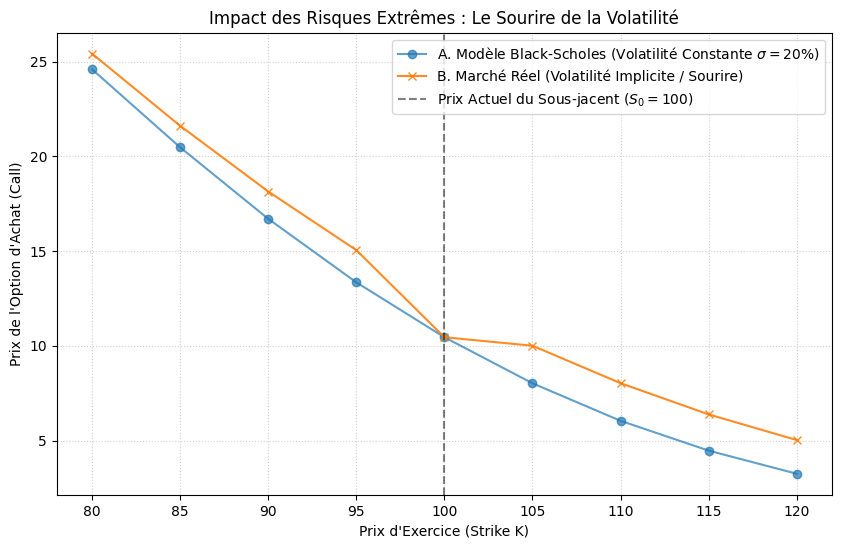

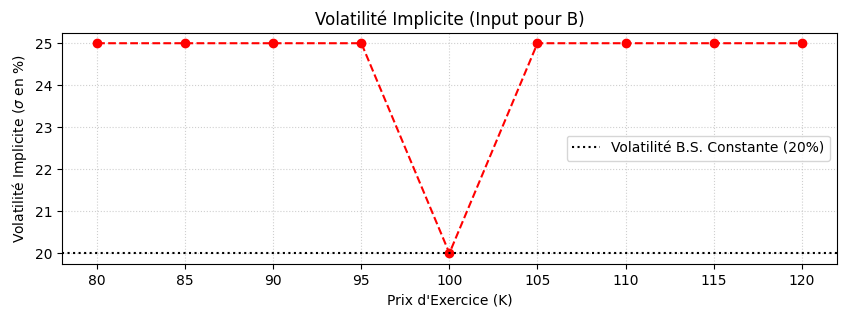

In [ ]:
# =================================================================
# 6. DEMONSTRATION : LE SOURIRE DE VOLATILITE
# =================================================================

# Inputs de base
S0_base = 100.0
T_base = 1.0
r_base = 0.05

# 1. Définir une gamme de prix d'exercice (K)
strikes = np.arange(80, 121, 5) # K de 80, 85, 90, ..., 120

# 2. Définir DEUX scénarios de Volatilité
# Scénario A : Black-Scholes (Volatilité constante, le modèle "naïf")
sigma_flat = 0.20  # 20% pour toutes les options

# Scénario B : Volatilité Implicite (le marché "réel")
# On augmente artificiellement la sigma pour les options OTM et ITM
sigmas_smile = np.where(strikes < S0_base, 0.25,  # 25% pour les options OTM Put (K<100)
                        np.where(strikes > S0_base, 0.25, # 25% pour les options OTM Call (K>100)
                                 0.20)) # 20% pour l'option ATM (K=100)

# 3. Calculer les prix Call pour les deux scénarios
prices_flat = [black_scholes_call(S0_base, K, T_base, r_base, sigma_flat) for K in strikes]
prices_smile = [black_scholes_call(S0_base, K, T_base, r_base, sigma_smile) for K, sigma_smile in zip(strikes, sigmas_smile)]


# 4. Création du graphique de démonstration
plt.figure(figsize=(10, 6))

# Tracer les deux courbes de prix
plt.plot(strikes, prices_flat, 'o-', label='A. Modèle Black-Scholes (Volatilité Constante $\sigma=20\%$)', alpha=0.7)
plt.plot(strikes, prices_smile, 'x-', label='B. Marché Réel (Volatilité Implicite / Sourire)', alpha=0.9)

# Marquage
plt.axvline(S0_base, color='k', linestyle='--', alpha=0.5, label='Prix Actuel du Sous-jacent ($S_0=100$)')
plt.title("Impact des Risques Extrêmes : Le Sourire de la Volatilité")
plt.xlabel("Prix d'Exercice (Strike K)")
plt.ylabel("Prix de l'Option d'Achat (Call)")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# Afficher le sourire de volatilité lui-même (la preuve)
plt.figure(figsize=(10, 3))
plt.plot(strikes, sigmas_smile * 100, 'r--', marker='o')
plt.axhline(sigma_flat * 100, color='k', linestyle=':', label='Volatilité B.S. Constante (20%)')
plt.title("Volatilité Implicite (Input pour B)")
plt.xlabel("Prix d'Exercice (K)")
plt.ylabel("Volatilité Implicite ($\sigma$ en %)")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()